# Summary of the Code:
Library Imports: Essential data science libraries like pandas, numpy, seaborn, matplotlib, and machine learning libraries from sklearn and LightGBM are imported. Additionally, plotly is used for interactive visualizations.

Data Loading and Preprocessing:
The Abalone dataset is loaded directly from the UCI repository.
Additional training and testing datasets are loaded.
Column names are standardized across datasets.
Datasets are merged to ensure consistency and avoid misinterpretations.
Dummy variables are created for the categorical 'Sex' column in both training and testing datasets.

Exploratory Data Analysis (EDA):
Box plots are generated to observe the distribution of features.
Detailed scatter plots and bar charts are created to explore relationships and distributions among the features based on the 'Rings' category, which represents the age of the abalones.
A pie chart visualizes the distribution of different 'Rings' values.

Feature Engineering:
The 'Rings' column, which is the target variable, is log-transformed to normalize its distribution.
A new 'Volume' feature is calculated from 'Length', 'Diameter', and 'Height' for both training and testing data.

Model Preparation:
Features are selected and standardized using StandardScaler.
PCA (Principal Component Analysis) is applied to reduce dimensionality while capturing the most variance possible in two principal components. Confidence ellipses are added to the PCA plot to visualize data spread and correlation.

Model Training and Optimization:
A LightGBM regressor is prepared for modeling.
Hyperparameter tuning is performed using Optuna to optimize model settings.
K-Fold cross-validation is implemented to validate the model’s effectiveness, averaging out the validation scores for robustness assessment.
The trained models are then used to predict the 'Rings' values for the test dataset.

Output Preparation and Export:
Predictions from the ensemble of models are averaged and converted back from their logarithmic form.
Results are compiled into a DataFrame and exported as a CSV file for submission or further analysis.

# Introduction: Abalone
Transforming Insights: Utilizing Box-Cox and Yeo-Johnson for data normalization.

Charting the Unseen: Unraveling feature distributions with detailed box plots.

Collective Strength: Enhancing predictions with a strategic ensemble of models.

The Ensemble Effect: Demonstrating the robustness of collective model intelligence.

# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import optuna
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import train_test_split

In [5]:
#plotly
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Prepration of Data
Abalone dataset was taken from UCI official website

In [6]:
# URL of the original abalone dataset from the UCI Repository.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 
                'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

df_uci_abalone = pd.read_csv(url, names=column_names)

print(df_uci_abalone.head())

  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  


In [7]:
##load training dataset
train_data = pd.read_csv('train.csv')
train_data.head()

id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0   0   F   0.550     0.430   0.150        0.7715          0.3285   
1   1   F   0.630     0.490   0.145        1.1300          0.4580   
2   2   I   0.160     0.110   0.025        0.0210          0.0055   
3   3   M   0.595     0.475   0.150        0.9145          0.3755   
4   4   I   0.555     0.425   0.130        0.7820          0.3695   

   Whole weight.2  Shell weight  Rings  
0          0.1465        0.2400     11  
1          0.2765        0.3200     11  
2          0.0030        0.0050      6  
3          0.2055        0.2500     10  
4          0.1600        0.1975      9

In [8]:
##load test dataset
test_data = pd.read_csv('test.csv')
test_data.head()

id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0  90615   M   0.645     0.475   0.155        1.2380          0.6185   
1  90616   M   0.580     0.460   0.160        0.9830          0.4785   
2  90617   M   0.560     0.420   0.140        0.8395          0.3525   
3  90618   M   0.570     0.490   0.145        0.8740          0.3525   
4  90619   I   0.415     0.325   0.110        0.3580          0.1575   

   Whole weight.2  Shell weight  
0          0.3125        0.3005  
1          0.2195        0.2750  
2          0.1845        0.2405  
3          0.1865        0.2350  
4          0.0670        0.1050

In [9]:
# Conversion of column names to suitable names

train_data.rename(columns={
    'Whole weight.1': 'Shucked weight',
    'Whole weight.2': 'Viscera weight'
}, inplace=True)

test_data.rename(columns={
    'Whole weight.1': 'Shucked weight',
    'Whole weight.2': 'Viscera weight'
}, inplace=True)

In [10]:
# Get common columns and merge them to avoid misinterpretation of data
common_columns = df_uci_abalone.columns.intersection(train_data.columns)

combined_train_data = pd.concat([df_uci_abalone[common_columns], train_data[common_columns]], axis=0)

combined_train_data.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

In [11]:
# Making "Sex" a dummy variable for train data
combined_train_data = pd.concat([combined_train_data, pd.get_dummies(combined_train_data["Sex"])], axis = 1)
combined_train_data = combined_train_data.drop(columns=["Sex"])
combined_train_data.head()

Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  F  I  M  
0         0.150     15  0  0  1  
1         0.070      7  0  0  1  
2         0.210      9  1  0  0  
3         0.155     10  0  0  1  
4         0.055      7  0  1  0

In [12]:
# Making "Sex" a dummy variable for test data
test_data = pd.concat([test_data, pd.get_dummies(test_data["Sex"])], axis = 1)
test_data = test_data.drop(columns=["Sex"])
test_data.head()

id  Length  Diameter  Height  Whole weight  Shucked weight  \
0  90615   0.645     0.475   0.155        1.2380          0.6185   
1  90616   0.580     0.460   0.160        0.9830          0.4785   
2  90617   0.560     0.420   0.140        0.8395          0.3525   
3  90618   0.570     0.490   0.145        0.8740          0.3525   
4  90619   0.415     0.325   0.110        0.3580          0.1575   

   Viscera weight  Shell weight  F  I  M  
0          0.3125        0.3005  0  0  1  
1          0.2195        0.2750  0  0  1  
2          0.1845        0.2405  0  0  1  
3          0.1865        0.2350  0  0  1  
4          0.0670        0.1050  0  1  0

# EDA to understand our data well!!!

In [13]:
# prepare data frames 
dfs = {}  # Create an empty dictionary to store data frames
for i in range(1, 30):
    dfs[f'df{i}'] = combined_train_data[combined_train_data.Rings == i]
    

colors = [
    'rgba(255, 128, 255, 0.8)', 'rgba(255, 128, 2, 0.8)', 'rgba(0, 255, 200, 0.8)',
    'rgba(255, 0, 0, 0.8)', 'rgba(0, 0, 255, 0.8)', 'rgba(0, 255, 0, 0.8)',
    'rgba(255, 255, 0, 0.8)', 'rgba(0, 255, 255, 0.8)', 'rgba(255, 0, 255, 0.8)',
    'rgba(192, 192, 192, 0.8)', 'rgba(128, 128, 128, 0.8)', 'rgba(128, 0, 0, 0.8)',
    'rgba(128, 128, 0, 0.8)', 'rgba(0, 128, 0, 0.8)', 'rgba(128, 0, 128, 0.8)',
    'rgba(0, 128, 128, 0.8)', 'rgba(0, 0, 128, 0.8)', 'rgba(139, 0, 0, 0.8)',
    'rgba(165, 42, 42, 0.8)', 'rgba(178, 34, 34, 0.8)', 'rgba(220, 20, 60, 0.8)',
    'rgba(255, 0, 0, 0.8)', 'rgba(255, 99, 71, 0.8)', 'rgba(255, 127, 80, 0.8)',
    'rgba(205, 92, 92, 0.8)', 'rgba(240, 128, 128, 0.8)', 'rgba(233, 150, 122, 0.8)',
    'rgba(250, 128, 114, 0.8)', 'rgba(255, 160, 122, 0.8)'
]

# Assuming 'dfs' is your dictionary containing data frames
data = []  # to hold all the traces

for i in range(1, 30):
    trace = go.Scatter(
        x = dfs[f'df{i}'].Length,
        y = dfs[f'df{i}']['Whole weight'],  # Note: Fixed the attribute access
        mode = "markers",
        name = f"Rings {i}",
        marker = dict(color = colors[i-1]),  # Use color from the predefined list
        text = dfs[f'df{i}'].Rings
    )
    data.append(trace)

# Define layout
layout = dict(title = 'Length vs Whole weight for each Rings category',
              xaxis= dict(title= 'Length', ticklen= 5, zeroline= False),
              yaxis= dict(title= 'Whole weight', ticklen= 5, zeroline= False)
             )

# Create the figure
fig = dict(data=data, layout=layout)
iplot(fig)

In [14]:
import plotly.graph_objs as go
from plotly.offline import iplot

# List of columns to plot
column_list = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']

# Calculate the mean of each feature grouped by 'Rings'
grouped_data = combined_train_data.groupby('Rings')[column_list].mean().reset_index()

# Create a list to hold all the traces
data = []

# Colors for each feature (just an example, you can choose any color scheme)
colors = ['rgba(255, 174, 255, 0.5)', 'rgba(255, 128, 2, 0.8)', 'rgba(0, 255, 200, 0.8)',
          'rgba(255, 0, 0, 0.8)', 'rgba(0, 0, 255, 0.8)', 'rgba(0, 255, 0, 0.8)', 'rgba(255, 255, 0, 0.8)']

# Generate a trace for each feature
for i, feature in enumerate(column_list):
    trace = go.Bar(
        x=grouped_data['Rings'],
        y=grouped_data[feature],
        name=feature,
        marker=dict(color=colors[i % len(colors)],  # Use modulo to cycle through colors if fewer than features
                    line=dict(color='rgb(0,0,0)', width=1.5)),
        text=grouped_data[feature]
    )
    data.append(trace)

# Layout for the bar chart
layout = go.Layout(
    title='Average Measurements by Rings',
    xaxis=dict(title='Rings (Age)'),
    yaxis=dict(title='Average Measurement'),
    barmode='group'
)

# Create the figure with data and layout
fig = go.Figure(data=data, layout=layout)

# Plot the figure
iplot(fig)


In [15]:
import plotly.graph_objs as go
from plotly.offline import iplot
import pandas as pd

# Calculate the frequency of each unique value in the 'Rings' column
rings_counts = combined_train_data['Rings'].value_counts().reset_index()
rings_counts.columns = ['Rings', 'Count']

# Create a pie chart
trace = go.Pie(labels=rings_counts['Rings'], values=rings_counts['Count'],
               hoverinfo='label+percent', textinfo='value')

layout = go.Layout(title='Pie Chart of Rings Distribution')

fig = go.Figure(data=[trace], layout=layout)

# Plot the figure
iplot(fig)

# Principle Component Analysis
Principal component analysis (PCA) is a dimensionality reduction and machine learning method used to simplify a large data set into a smaller set while still maintaining significant patterns and trends.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [17]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


In [18]:
# Data preparation: Feature Engineering
features_to_exclude = ['F', 'I', 'M', 'Rings']
features = combined_train_data.drop(features_to_exclude, axis=1)
labels = combined_train_data['Rings']

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA analysis
pca = PCA(n_components=2, whiten=True)
projected = pca.fit_transform(features_scaled)

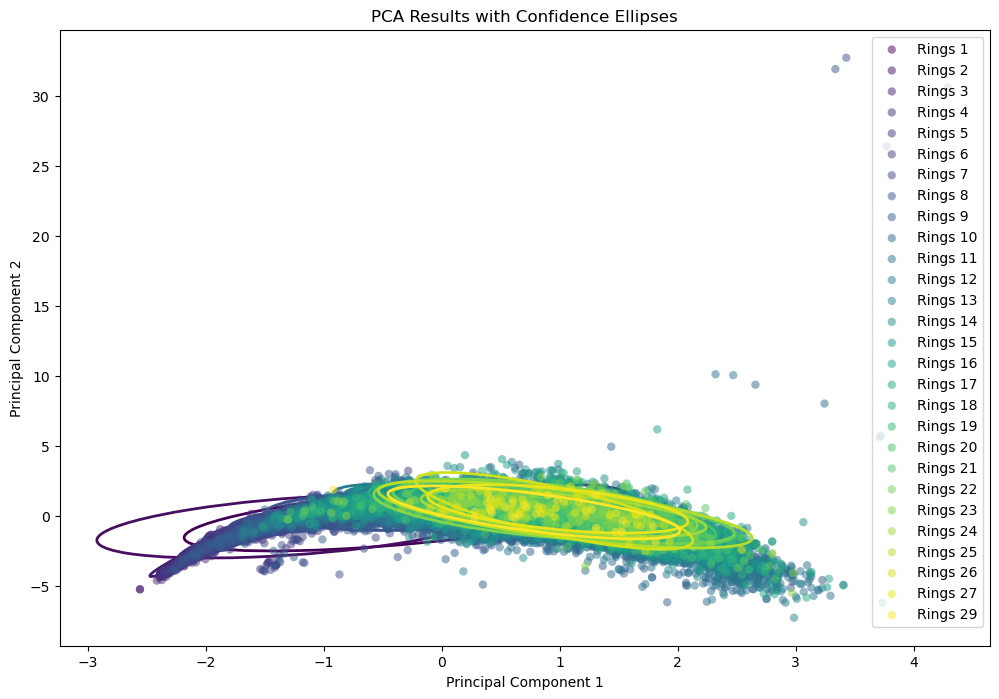

In [19]:
# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Color map
colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(labels))))

for label, color in zip(np.unique(labels), colors):
    group = projected[labels == label]
    ax.scatter(group[:, 0], group[:, 1], c=[color], label=f'Rings {label}', alpha=0.5, edgecolor='none')

    # Add a confidence ellipse
    confidence_ellipse(group[:, 0], group[:, 1], ax, n_std=2.0, edgecolor=color, linewidth=2)

ax.legend()
ax.set_title('PCA Results with Confidence Ellipses')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.show()

# Feature Engineering

In [20]:
 combined_train_data.Rings = np.log1p(combined_train_data.Rings)

In [21]:
combined_train_data['Rings'].describe()

count    94792.000000
mean         2.329925
std          0.285596
min          0.693147
25%          2.197225
50%          2.302585
75%          2.484907
max          3.401197
Name: Rings, dtype: float64

In [22]:
# Volume calculations for train & test data
combined_train_data['Volume'] = combined_train_data['Length'] * combined_train_data['Diameter'] * combined_train_data['Height']
test_data['Volume'] = test_data['Length'] * test_data['Diameter'] * test_data['Height']

In [23]:
# Features List without Rings: Data Prepration
features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Volume', 'F',
       'I', 'M']
numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Volume']  

In [24]:
combined_train_data.astype(float)
test_data.astype(float)

id  Length  Diameter  Height  Whole weight  Shucked weight  \
0       90615.0   0.645     0.475   0.155        1.2380          0.6185   
1       90616.0   0.580     0.460   0.160        0.9830          0.4785   
2       90617.0   0.560     0.420   0.140        0.8395          0.3525   
3       90618.0   0.570     0.490   0.145        0.8740          0.3525   
4       90619.0   0.415     0.325   0.110        0.3580          0.1575   
...         ...     ...       ...     ...           ...             ...   
60406  151021.0   0.345     0.260   0.085        0.1775          0.0735   
60407  151022.0   0.525     0.410   0.145        0.8445          0.3885   
60408  151023.0   0.590     0.440   0.155        1.1220          0.3930   
60409  151024.0   0.660     0.525   0.190        1.4935          0.5885   
60410  151025.0   0.430     0.340   0.120        0.4150          0.1525   

       Viscera weight  Shell weight    F    I    M    Volume  
0              0.3125        0.3005  0.0  0.0  1.0  0.047488  
1              0.2195        0.2750  0.0  0.0  1.0  0.042688  
2              0.1845        0.2405  0.0  0.0  1.0  0.032928  
3              0.1865        0.2350  0.0  0.0  1.0  0.040498  
4              0.0670        0.1050  0.0  1.0  0.0  0.014836  
...               ...           ...  ...  ...  ...       ...  
60406          0.0265        0.0500  0.0  1.0  0.0  0.007625  
60407          0.1670        0.2050  1.0  0.0  0.0  0.031211  
60408          0.2000        0.2650  0.0  1.0  0.0  0.040238  
60409          0.3575        0.4350  1.0  0.0  0.0  0.065835  
60410          0.0910        0.0905  1.0  0.0  0.0  0.017544  

[60411 rows x 12 columns]

In [25]:
##Model
X = combined_train_data[features]
y = combined_train_data['Rings']
X_test = test_data[features]

In [26]:
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
print(X_tr.shape, y_tr.shape, X_va.shape, y_va.shape)

(66354, 11) (66354,) (28438, 11) (28438,)


# LightGBM

In [27]:
# Define RMSLE as a custom evaluation indicator
from sklearn.metrics import mean_squared_log_error
def rmsle(y_true, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    return rmsle

In [28]:
params_base = {
    'objective':'RMSE',
    'random_seed': 1234,
    'learning_rate': 0.02,
    'min_data_in_bin': 3,
    'bagging_freq': 1,
    'bagging_seed': 0,
    'verbose': -1,
}

In [29]:
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb

def objective(trial):
  params_tuning = {
      'num_leaves': trial.suggest_int('num_leaves', 50, 200),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 30),
      'max_bin': trial.suggest_int('max_bin', 200, 400),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 0.95),
      'feature_fraction': trial.suggest_float('feature_fraction', 0.35, 0.65),
      'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.01, 1, log=True),
      'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 1, log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 1, log=True),
  }

  params_tuning.update(params_base)

  lgb_train = lgb.Dataset(X_tr, y_tr)
  lgb_eval = lgb.Dataset(X_va, y_va)

  model = lgb.train(params_tuning,
                    lgb_train,
                    num_boost_round=10000,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train', 'valid'],
                    callbacks=[lgb.early_stopping(100),
                               lgb.log_evaluation(500)])

  y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
  score =  np.sqrt(mean_squared_log_error(y_va, y_va_pred))
  print('')

  return score

In [30]:
##Optune for 100 trials
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0), direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-04-30 13:33:54,251] A new study created in memory with name: no-name-437708f9-96e1-41f9-86f1-ed76b9a108c7


Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0218339	valid's l2: 0.0226285
[1000]	train's l2: 0.0218111	valid's l2: 0.0226119
[1500]	train's l2: 0.0218057	valid's l2: 0.0226084
[2000]	train's l2: 0.0218	valid's l2: 0.0226039
[2500]	train's l2: 0.0217935	valid's l2: 0.0225987
[3000]	train's l2: 0.0217905	valid's l2: 0.0225963
[3500]	train's l2: 0.0217877	valid's l2: 0.0225946
[4000]	train's l2: 0.0217847	valid's l2: 0.0225925
[4500]	train's l2: 0.0217828	valid's l2: 0.0225914
[5000]	train's l2: 0.0217806	valid's l2: 0.0225898
Early stopping, best iteration is:
[5254]	train's l2: 0.0217792	valid's l2: 0.022589


[I 2024-04-30 13:34:18,282] Trial 0 finished with value: 0.04509880490894338 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 22, 'max_bin': 321, 'bagging_fraction': 0.8817324774495345, 'feature_fraction': 0.4770964398016714, 'min_gain_to_split': 0.19578897201213002, 'lambda_l1': 0.07501954443620121, 'lambda_l2': 0.6074996073425692}. Best is trial 0 with value: 0.04509880490894338.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0231067	valid's l2: 0.0233138
[1000]	train's l2: 0.023094	valid's l2: 0.0233037
[1500]	train's l2: 0.0230901	valid's l2: 0.023301
Early stopping, best iteration is:
[1418]	train's l2: 0.0230901	valid's l2: 0.023301


[I 2024-04-30 13:34:25,665] Trial 1 finished with value: 0.045721982102602164 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 359, 'bagging_fraction': 0.8793342379629356, 'feature_fraction': 0.5204133683281797, 'min_gain_to_split': 0.70989362574059, 'lambda_l1': 0.013869861245357327, 'lambda_l2': 0.014936835544198456}. Best is trial 0 with value: 0.04509880490894338.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0226694	valid's l2: 0.0229871
[1000]	train's l2: 0.0226644	valid's l2: 0.0229838
Early stopping, best iteration is:
[1099]	train's l2: 0.0226624	valid's l2: 0.0229825


[I 2024-04-30 13:34:30,928] Trial 2 finished with value: 0.04544418562369919 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 26, 'max_bin': 356, 'bagging_fraction': 0.9305018222370228, 'feature_fraction': 0.6435855026698292, 'min_gain_to_split': 0.39656750817710085, 'lambda_l1': 0.08374496868436809, 'lambda_l2': 0.3639639356786389}. Best is trial 0 with value: 0.04509880490894338.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0211582	valid's l2: 0.0223809
[1000]	train's l2: 0.0211442	valid's l2: 0.0223742
[1500]	train's l2: 0.0211373	valid's l2: 0.0223715
[2000]	train's l2: 0.0211321	valid's l2: 0.0223682
Early stopping, best iteration is:
[2239]	train's l2: 0.0211293	valid's l2: 0.0223673


[I 2024-04-30 13:34:43,431] Trial 3 finished with value: 0.044902284778946325 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 20, 'max_bin': 228, 'bagging_fraction': 0.9417003375574375, 'feature_fraction': 0.5065544965250215, 'min_gain_to_split': 0.06750312521595925, 'lambda_l1': 0.0338151426782029, 'lambda_l2': 0.35356346291488117}. Best is trial 3 with value: 0.044902284778946325.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0221018	valid's l2: 0.0226868
[1000]	train's l2: 0.022086	valid's l2: 0.0226762
[1500]	train's l2: 0.0220801	valid's l2: 0.0226722
[2000]	train's l2: 0.0220754	valid's l2: 0.0226684
[2500]	train's l2: 0.0220688	valid's l2: 0.0226639
[3000]	train's l2: 0.0220658	valid's l2: 0.022662
Early stopping, best iteration is:
[3309]	train's l2: 0.0220647	valid's l2: 0.0226616


[I 2024-04-30 13:34:55,784] Trial 4 finished with value: 0.04515014287311115 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 18, 'max_bin': 203, 'bagging_fraction': 0.8926453245613816, 'feature_fraction': 0.5336287168167264, 'min_gain_to_split': 0.17134364197119656, 'lambda_l1': 0.7717846862118062, 'lambda_l2': 0.23101522250182369}. Best is trial 3 with value: 0.044902284778946325.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0218953	valid's l2: 0.0226138
[1000]	train's l2: 0.0218742	valid's l2: 0.0225994
[1500]	train's l2: 0.0218651	valid's l2: 0.0225938
[2000]	train's l2: 0.0218592	valid's l2: 0.0225898
[2500]	train's l2: 0.0218534	valid's l2: 0.0225857
Early stopping, best iteration is:
[2739]	train's l2: 0.0218523	valid's l2: 0.0225847


[I 2024-04-30 13:35:07,507] Trial 5 finished with value: 0.04509559549875814 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.8090338207443906, 'feature_fraction': 0.5500300146337003, 'min_gain_to_split': 0.21941976179005757, 'lambda_l1': 0.02634905974115613, 'lambda_l2': 0.01810725406663109}. Best is trial 3 with value: 0.044902284778946325.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0187119	valid's l2: 0.0221146
[1000]	train's l2: 0.0172621	valid's l2: 0.0220106
Early stopping, best iteration is:
[1083]	train's l2: 0.0171445	valid's l2: 0.0220051


[I 2024-04-30 13:35:44,750] Trial 6 finished with value: 0.044603970408776235 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 12, 'max_bin': 314, 'bagging_fraction': 0.865790227019348, 'feature_fraction': 0.6465121514177679, 'min_gain_to_split': 0.015998881492631498, 'lambda_l1': 0.02616697456085447, 'lambda_l2': 0.021019338091154416}. Best is trial 6 with value: 0.044603970408776235.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.019211	valid's l2: 0.022741
[1000]	train's l2: 0.0177553	valid's l2: 0.0223721
[1500]	train's l2: 0.0172923	valid's l2: 0.0223213
[2000]	train's l2: 0.0171129	valid's l2: 0.0223089
Early stopping, best iteration is:
[1942]	train's l2: 0.0171236	valid's l2: 0.0223068


[I 2024-04-30 13:36:37,589] Trial 7 finished with value: 0.044889467832274745 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 9, 'max_bin': 293, 'bagging_fraction': 0.8366638388002404, 'feature_fraction': 0.3976908750936559, 'min_gain_to_split': 0.016624564693643644, 'lambda_l1': 0.20542778286285945, 'lambda_l2': 0.018895826938026012}. Best is trial 6 with value: 0.044603970408776235.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0198275	valid's l2: 0.0220599
[1000]	train's l2: 0.0190254	valid's l2: 0.0219478
Early stopping, best iteration is:
[1282]	train's l2: 0.0188223	valid's l2: 0.0219331


[I 2024-04-30 13:37:06,645] Trial 8 finished with value: 0.04453189877367859 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 365, 'bagging_fraction': 0.8145651913689592, 'feature_fraction': 0.6013834722496412, 'min_gain_to_split': 0.015566709318481201, 'lambda_l1': 0.8972612866432508, 'lambda_l2': 0.08655704137361815}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0173687	valid's l2: 0.021993
Early stopping, best iteration is:
[755]	train's l2: 0.0168298	valid's l2: 0.0219717


[I 2024-04-30 13:37:48,793] Trial 9 finished with value: 0.04456624884486081 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 19, 'max_bin': 348, 'bagging_fraction': 0.8058781688381481, 'feature_fraction': 0.43484208877292285, 'min_gain_to_split': 0.017393745944806985, 'lambda_l1': 0.0391093317225106, 'lambda_l2': 0.0172764870082179}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0207067	valid's l2: 0.0222092
[1000]	train's l2: 0.0206491	valid's l2: 0.0221864
[1500]	train's l2: 0.0206118	valid's l2: 0.0221729
[2000]	train's l2: 0.0205824	valid's l2: 0.0221601
[2500]	train's l2: 0.0205604	valid's l2: 0.0221533
[3000]	train's l2: 0.0205451	valid's l2: 0.022149
[3500]	train's l2: 0.0205292	valid's l2: 0.0221409
[4000]	train's l2: 0.0205156	valid's l2: 0.022136
[4500]	train's l2: 0.0204975	valid's l2: 0.0221294
Early stopping, best iteration is:
[4601]	train's l2: 0.0204948	valid's l2: 0.0221286


[I 2024-04-30 13:38:11,551] Trial 10 finished with value: 0.044694644330992614 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 3, 'max_bin': 391, 'bagging_fraction': 0.8357161822219233, 'feature_fraction': 0.5842248758067577, 'min_gain_to_split': 0.05360980835049379, 'lambda_l1': 0.5572928896695892, 'lambda_l2': 0.06472055193755138}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.019095	valid's l2: 0.0220335
[1000]	train's l2: 0.0189285	valid's l2: 0.0220049
[1500]	train's l2: 0.0188384	valid's l2: 0.0219909
[2000]	train's l2: 0.0187842	valid's l2: 0.0219865
Early stopping, best iteration is:
[1987]	train's l2: 0.018786	valid's l2: 0.0219861


[I 2024-04-30 13:38:45,533] Trial 11 finished with value: 0.0445738739790505 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 30, 'max_bin': 392, 'bagging_fraction': 0.8048269531482597, 'feature_fraction': 0.42252207893432947, 'min_gain_to_split': 0.032694791324974944, 'lambda_l1': 0.20171034585797376, 'lambda_l2': 0.05966483765307864}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0187257	valid's l2: 0.0227544
[1000]	train's l2: 0.0167698	valid's l2: 0.0224445
[1500]	train's l2: 0.0160454	valid's l2: 0.0224055
Early stopping, best iteration is:
[1448]	train's l2: 0.0160918	valid's l2: 0.0224039


[I 2024-04-30 13:39:42,600] Trial 12 finished with value: 0.04497472363797981 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 7, 'max_bin': 284, 'bagging_fraction': 0.8308331782748726, 'feature_fraction': 0.35366831487406775, 'min_gain_to_split': 0.01027512907497689, 'lambda_l1': 0.31211954149297433, 'lambda_l2': 0.1445025316423963}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0187171	valid's l2: 0.0220393
[1000]	train's l2: 0.0184043	valid's l2: 0.022001
Early stopping, best iteration is:
[1353]	train's l2: 0.0182889	valid's l2: 0.0219916


[I 2024-04-30 13:40:13,265] Trial 13 finished with value: 0.0445814951661349 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 23, 'max_bin': 265, 'bagging_fraction': 0.8023162335241206, 'feature_fraction': 0.4474335292541354, 'min_gain_to_split': 0.0258987353293739, 'lambda_l1': 0.050154371243898675, 'lambda_l2': 0.04360382595127816}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.019012	valid's l2: 0.0220322
[1000]	train's l2: 0.0188482	valid's l2: 0.022001
[1500]	train's l2: 0.0187701	valid's l2: 0.0219936
Early stopping, best iteration is:
[1856]	train's l2: 0.0187222	valid's l2: 0.0219865


[I 2024-04-30 13:40:35,502] Trial 14 finished with value: 0.04457917196640391 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 16, 'max_bin': 369, 'bagging_fraction': 0.8538960519238117, 'feature_fraction': 0.5906544253097181, 'min_gain_to_split': 0.034458503243006346, 'lambda_l1': 0.014196734772576672, 'lambda_l2': 0.03813188382424411}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0201199	valid's l2: 0.0221282
[1000]	train's l2: 0.019005	valid's l2: 0.0219885
Early stopping, best iteration is:
[1310]	train's l2: 0.0186528	valid's l2: 0.0219719


[I 2024-04-30 13:41:15,534] Trial 15 finished with value: 0.044565158559764034 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 8, 'max_bin': 329, 'bagging_fraction': 0.8229443312000123, 'feature_fraction': 0.45712611044251367, 'min_gain_to_split': 0.010581388691157273, 'lambda_l1': 0.9860773825279063, 'lambda_l2': 0.10799641597489053}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0215947	valid's l2: 0.0224346
[1000]	train's l2: 0.0215483	valid's l2: 0.0224049
[1500]	train's l2: 0.0215253	valid's l2: 0.022392
[2000]	train's l2: 0.0215106	valid's l2: 0.0223842
[2500]	train's l2: 0.0215013	valid's l2: 0.0223785
[3000]	train's l2: 0.021492	valid's l2: 0.0223738
[3500]	train's l2: 0.0214839	valid's l2: 0.0223691
[4000]	train's l2: 0.0214772	valid's l2: 0.0223646
[4500]	train's l2: 0.0214699	valid's l2: 0.0223607
[5000]	train's l2: 0.0214637	valid's l2: 0.0223569
[5500]	train's l2: 0.0214583	valid's l2: 0.0223529
[6000]	train's l2: 0.0214549	valid's l2: 0.0223514
[6500]	train's l2: 0.0214509	valid's l2: 0.0223485
[7000]	train's l2: 0.0214472	valid's l2: 0.0223459
[7500]	train's l2: 0.0214419	valid's l2: 0.0223426
Early stopping, best iteration is:
[7896]	train's l2: 0.0214402	valid's l2: 0.0223416


[I 2024-04-30 13:41:44,191] Trial 16 finished with value: 0.044879559138940706 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 4, 'max_bin': 320, 'bagging_fraction': 0.8506287494223203, 'feature_fraction': 0.46704509141627265, 'min_gain_to_split': 0.08173486363391959, 'lambda_l1': 0.9793529142759247, 'lambda_l2': 0.10933717282181019}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0191957	valid's l2: 0.0220838
[1000]	train's l2: 0.0178559	valid's l2: 0.0219802
Early stopping, best iteration is:
[1367]	train's l2: 0.0174948	valid's l2: 0.0219593


[I 2024-04-30 13:42:22,487] Trial 17 finished with value: 0.04455834699350694 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 9, 'max_bin': 268, 'bagging_fraction': 0.903668943079996, 'feature_fraction': 0.5782734195056952, 'min_gain_to_split': 0.010524953932623326, 'lambda_l1': 0.40036296687257683, 'lambda_l2': 0.17645605947100956}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0204337	valid's l2: 0.0221801
[1000]	train's l2: 0.0204118	valid's l2: 0.0221716
Early stopping, best iteration is:
[1138]	train's l2: 0.0204088	valid's l2: 0.0221704


[I 2024-04-30 13:42:33,593] Trial 18 finished with value: 0.044731335584685485 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 10, 'max_bin': 260, 'bagging_fraction': 0.9062811147141909, 'feature_fraction': 0.5936476006224242, 'min_gain_to_split': 0.050452827878729054, 'lambda_l1': 0.35351762246546986, 'lambda_l2': 0.20079738946660455}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0203943	valid's l2: 0.0222835
[1000]	train's l2: 0.0197966	valid's l2: 0.0221344
[1500]	train's l2: 0.0196049	valid's l2: 0.0220984
[2000]	train's l2: 0.0194852	valid's l2: 0.0220785
[2500]	train's l2: 0.0193947	valid's l2: 0.0220642
[3000]	train's l2: 0.0193359	valid's l2: 0.0220564
Early stopping, best iteration is:
[2984]	train's l2: 0.0193371	valid's l2: 0.0220561


[I 2024-04-30 13:42:59,477] Trial 19 finished with value: 0.044638559343246925 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 6, 'max_bin': 244, 'bagging_fraction': 0.9117464952591412, 'feature_fraction': 0.614032532841996, 'min_gain_to_split': 0.023713455583116, 'lambda_l1': 0.160899638697105, 'lambda_l2': 0.4826811596414585}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0188949	valid's l2: 0.0220876
[1000]	train's l2: 0.0179495	valid's l2: 0.0219967
Early stopping, best iteration is:
[1033]	train's l2: 0.017932	valid's l2: 0.0219956


[I 2024-04-30 13:43:29,666] Trial 20 finished with value: 0.04458425079852422 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 11, 'max_bin': 278, 'bagging_fraction': 0.9181622261499105, 'feature_fraction': 0.5593584697254533, 'min_gain_to_split': 0.010803484364556816, 'lambda_l1': 0.4499062959998981, 'lambda_l2': 0.9014049617423665}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0197609	valid's l2: 0.0221024
[1000]	train's l2: 0.0183596	valid's l2: 0.0219826
Early stopping, best iteration is:
[1358]	train's l2: 0.0178153	valid's l2: 0.0219675


[I 2024-04-30 13:44:09,232] Trial 21 finished with value: 0.044563461314491355 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 7, 'max_bin': 335, 'bagging_fraction': 0.826634011955394, 'feature_fraction': 0.4858416937325188, 'min_gain_to_split': 0.010042470813512736, 'lambda_l1': 0.6894933348449637, 'lambda_l2': 0.09181557182599813}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0197008	valid's l2: 0.0220842
[1000]	train's l2: 0.0188605	valid's l2: 0.0219751
Early stopping, best iteration is:
[1397]	train's l2: 0.0185821	valid's l2: 0.0219588


[I 2024-04-30 13:44:48,185] Trial 22 finished with value: 0.04455901312132455 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 5, 'max_bin': 369, 'bagging_fraction': 0.8209512996727593, 'feature_fraction': 0.490151547084182, 'min_gain_to_split': 0.01628491870017004, 'lambda_l1': 0.672484575840535, 'lambda_l2': 0.06945253696725935}. Best is trial 8 with value: 0.04453189877367859.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0189996	valid's l2: 0.0220594
[1000]	train's l2: 0.0182274	valid's l2: 0.0219342
Early stopping, best iteration is:
[1354]	train's l2: 0.0180502	valid's l2: 0.0219207


[I 2024-04-30 13:45:22,555] Trial 23 finished with value: 0.04452720088096751 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 5, 'max_bin': 371, 'bagging_fraction': 0.8955115127045712, 'feature_fraction': 0.6196949470293618, 'min_gain_to_split': 0.017965549502281363, 'lambda_l1': 0.3224478262395022, 'lambda_l2': 0.034700162416548205}. Best is trial 23 with value: 0.04452720088096751.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0206139	valid's l2: 0.0222066
[1000]	train's l2: 0.0204762	valid's l2: 0.022157
[1500]	train's l2: 0.0204248	valid's l2: 0.0221444
[2000]	train's l2: 0.0203556	valid's l2: 0.0221159
[2500]	train's l2: 0.0203049	valid's l2: 0.0220998
[3000]	train's l2: 0.0202776	valid's l2: 0.0220895
[3500]	train's l2: 0.0202534	valid's l2: 0.0220812
Early stopping, best iteration is:
[3517]	train's l2: 0.0202518	valid's l2: 0.0220805


[I 2024-04-30 13:45:47,529] Trial 24 finished with value: 0.04465842085070311 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 15, 'max_bin': 379, 'bagging_fraction': 0.8955988757965436, 'feature_fraction': 0.6209162315664847, 'min_gain_to_split': 0.037937930784455995, 'lambda_l1': 0.29711883618793, 'lambda_l2': 0.032455923693586686}. Best is trial 23 with value: 0.04452720088096751.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0211916	valid's l2: 0.022416
[1000]	train's l2: 0.0211765	valid's l2: 0.0224077
[1500]	train's l2: 0.0211698	valid's l2: 0.0224046
[2000]	train's l2: 0.0211644	valid's l2: 0.0224014
[2500]	train's l2: 0.0211594	valid's l2: 0.0223976
[3000]	train's l2: 0.0211559	valid's l2: 0.0223955
[3500]	train's l2: 0.0211541	valid's l2: 0.0223948
[4000]	train's l2: 0.0211517	valid's l2: 0.0223931
Early stopping, best iteration is:
[4314]	train's l2: 0.0211499	valid's l2: 0.0223926


[I 2024-04-30 13:46:04,548] Trial 25 finished with value: 0.04492161130642642 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 2, 'max_bin': 302, 'bagging_fraction': 0.8957969210568051, 'feature_fraction': 0.566327980037316, 'min_gain_to_split': 0.11203165966330063, 'lambda_l1': 0.42085445829686907, 'lambda_l2': 0.17518387068619004}. Best is trial 23 with value: 0.04452720088096751.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.019145	valid's l2: 0.0220628
[1000]	train's l2: 0.0184702	valid's l2: 0.0219628
[1500]	train's l2: 0.0182271	valid's l2: 0.021932
Early stopping, best iteration is:
[1645]	train's l2: 0.0181648	valid's l2: 0.021924


[I 2024-04-30 13:46:40,284] Trial 26 finished with value: 0.04452558913983956 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 10, 'max_bin': 399, 'bagging_fraction': 0.8659743365832514, 'feature_fraction': 0.6251224949449989, 'min_gain_to_split': 0.023285309713787828, 'lambda_l1': 0.14746371650577664, 'lambda_l2': 0.0311616777305748}. Best is trial 26 with value: 0.04452558913983956.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0188698	valid's l2: 0.0220168
[1000]	train's l2: 0.0182402	valid's l2: 0.0219316
[1500]	train's l2: 0.0180284	valid's l2: 0.0219109
Early stopping, best iteration is:
[1645]	train's l2: 0.0179619	valid's l2: 0.0219028


[I 2024-04-30 13:47:08,163] Trial 27 finished with value: 0.04450778312311457 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 12, 'max_bin': 400, 'bagging_fraction': 0.8675426045146947, 'feature_fraction': 0.6170190872270966, 'min_gain_to_split': 0.022808181043499375, 'lambda_l1': 0.12038028583328203, 'lambda_l2': 0.010206604333394358}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0189047	valid's l2: 0.0220189
[1000]	train's l2: 0.0184045	valid's l2: 0.0219538
[1500]	train's l2: 0.0181729	valid's l2: 0.0219253
Early stopping, best iteration is:
[1867]	train's l2: 0.0180592	valid's l2: 0.0219161


[I 2024-04-30 13:47:45,935] Trial 28 finished with value: 0.04452667651549183 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 16, 'max_bin': 393, 'bagging_fraction': 0.8624125446253019, 'feature_fraction': 0.6267185575467357, 'min_gain_to_split': 0.023261092834078276, 'lambda_l1': 0.12370309102548395, 'lambda_l2': 0.012182423049494583}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0210486	valid's l2: 0.0223417
[1000]	train's l2: 0.0210347	valid's l2: 0.0223327
Early stopping, best iteration is:
[1155]	train's l2: 0.0210315	valid's l2: 0.0223308


[I 2024-04-30 13:47:55,381] Trial 29 finished with value: 0.04486906037655508 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 18, 'max_bin': 400, 'bagging_fraction': 0.8670173880540726, 'feature_fraction': 0.6499027535890491, 'min_gain_to_split': 0.12832182320456154, 'lambda_l1': 0.12047700282994579, 'lambda_l2': 0.010854930667044729}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0199245	valid's l2: 0.0221057
[1000]	train's l2: 0.0198327	valid's l2: 0.0220848
[1500]	train's l2: 0.0197767	valid's l2: 0.0220703
Early stopping, best iteration is:
[1869]	train's l2: 0.0197482	valid's l2: 0.0220638


[I 2024-04-30 13:48:13,627] Trial 30 finished with value: 0.0446444529225749 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 22, 'max_bin': 384, 'bagging_fraction': 0.8500429961831634, 'feature_fraction': 0.6230116188260704, 'min_gain_to_split': 0.0438571374730425, 'lambda_l1': 0.11125106668827763, 'lambda_l2': 0.010382080175806167}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0186841	valid's l2: 0.0220011
[1000]	train's l2: 0.0182775	valid's l2: 0.0219409
[1500]	train's l2: 0.01811	valid's l2: 0.0219186
Early stopping, best iteration is:
[1645]	train's l2: 0.0180606	valid's l2: 0.0219136


[I 2024-04-30 13:48:48,266] Trial 31 finished with value: 0.04451906634766236 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 14, 'max_bin': 399, 'bagging_fraction': 0.8668012159716989, 'feature_fraction': 0.6223248948401053, 'min_gain_to_split': 0.02411886543721362, 'lambda_l1': 0.14880674161886184, 'lambda_l2': 0.03137682933523064}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0186743	valid's l2: 0.0220083
[1000]	train's l2: 0.0183056	valid's l2: 0.0219622
[1500]	train's l2: 0.0181672	valid's l2: 0.021945
Early stopping, best iteration is:
[1716]	train's l2: 0.0181101	valid's l2: 0.0219378


[I 2024-04-30 13:49:14,841] Trial 32 finished with value: 0.044536580179842813 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 14, 'max_bin': 400, 'bagging_fraction': 0.8704197881315384, 'feature_fraction': 0.631394703621761, 'min_gain_to_split': 0.02626884681485898, 'lambda_l1': 0.0670752520000409, 'lambda_l2': 0.025895376959499974}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0184382	valid's l2: 0.0220236
Early stopping, best iteration is:
[672]	train's l2: 0.0182949	valid's l2: 0.0220032


[I 2024-04-30 13:49:43,544] Trial 33 finished with value: 0.0445975254185994 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 16, 'max_bin': 380, 'bagging_fraction': 0.8800726682470281, 'feature_fraction': 0.6065414165203957, 'min_gain_to_split': 0.02228633329586773, 'lambda_l1': 0.14800939285848494, 'lambda_l2': 0.01332337343248904}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0199873	valid's l2: 0.0221383
[1000]	train's l2: 0.0199528	valid's l2: 0.0221245
Early stopping, best iteration is:
[1155]	train's l2: 0.0199454	valid's l2: 0.0221218


[I 2024-04-30 13:49:56,927] Trial 34 finished with value: 0.044691806217266546 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 13, 'max_bin': 387, 'bagging_fraction': 0.8571906585149839, 'feature_fraction': 0.6320858697743419, 'min_gain_to_split': 0.05971113492169608, 'lambda_l1': 0.08784653317391136, 'lambda_l2': 0.023995589962641967}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.023435	valid's l2: 0.0235511
Early stopping, best iteration is:
[712]	train's l2: 0.0234283	valid's l2: 0.0235456


[I 2024-04-30 13:50:00,945] Trial 35 finished with value: 0.04593632299062784 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 17, 'max_bin': 353, 'bagging_fraction': 0.8433302889639048, 'feature_fraction': 0.5204345384312109, 'min_gain_to_split': 0.9260271129377927, 'lambda_l1': 0.06561226664123924, 'lambda_l2': 0.012457854815052433}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0224894	valid's l2: 0.0229298
[1000]	train's l2: 0.0224729	valid's l2: 0.0229174
[1500]	train's l2: 0.0224691	valid's l2: 0.0229144
Early stopping, best iteration is:
[1418]	train's l2: 0.0224691	valid's l2: 0.0229144


[I 2024-04-30 13:50:08,411] Trial 36 finished with value: 0.045380287903980264 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 21, 'max_bin': 399, 'bagging_fraction': 0.8861448868816277, 'feature_fraction': 0.5421123676126904, 'min_gain_to_split': 0.36625723430378176, 'lambda_l1': 0.2244436841042321, 'lambda_l2': 0.0482615954450525}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.019299	valid's l2: 0.0220489
[1000]	train's l2: 0.01901	valid's l2: 0.0219928
[1500]	train's l2: 0.0188905	valid's l2: 0.0219727
Early stopping, best iteration is:
[1407]	train's l2: 0.0189019	valid's l2: 0.0219724


[I 2024-04-30 13:50:37,045] Trial 37 finished with value: 0.044566879341480466 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 11, 'max_bin': 377, 'bagging_fraction': 0.861354025324469, 'feature_fraction': 0.6355953665867315, 'min_gain_to_split': 0.030635468568431915, 'lambda_l1': 0.14686512975964439, 'lambda_l2': 0.01463454311976739}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0204938	valid's l2: 0.0222005
[1000]	train's l2: 0.0204633	valid's l2: 0.0221852
[1500]	train's l2: 0.0204518	valid's l2: 0.0221822
Early stopping, best iteration is:
[1418]	train's l2: 0.0204526	valid's l2: 0.0221821


[I 2024-04-30 13:50:54,425] Trial 38 finished with value: 0.044740080642141265 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 14, 'max_bin': 356, 'bagging_fraction': 0.876417469464991, 'feature_fraction': 0.5689553663499652, 'min_gain_to_split': 0.07457077374743694, 'lambda_l1': 0.0974593139159543, 'lambda_l2': 0.026228643190362427}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0189774	valid's l2: 0.0220158
[1000]	train's l2: 0.0186454	valid's l2: 0.021957
[1500]	train's l2: 0.018509	valid's l2: 0.0219401
Early stopping, best iteration is:
[1853]	train's l2: 0.0184299	valid's l2: 0.0219309


[I 2024-04-30 13:51:23,897] Trial 39 finished with value: 0.0445327818986755 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 24, 'max_bin': 389, 'bagging_fraction': 0.8853288678069708, 'feature_fraction': 0.6056130831144262, 'min_gain_to_split': 0.021295734896644086, 'lambda_l1': 0.2533961032786985, 'lambda_l2': 0.01638399587290751}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.017399	valid's l2: 0.0220256
Early stopping, best iteration is:
[653]	train's l2: 0.0168722	valid's l2: 0.0219904


[I 2024-04-30 13:52:12,388] Trial 40 finished with value: 0.04458324531975237 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 13, 'max_bin': 359, 'bagging_fraction': 0.8693027889354111, 'feature_fraction': 0.648848810167351, 'min_gain_to_split': 0.013130709171010677, 'lambda_l1': 0.1837768409002207, 'lambda_l2': 0.02059147268938908}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0188318	valid's l2: 0.0220663
[1000]	train's l2: 0.0180419	valid's l2: 0.0219688
[1500]	train's l2: 0.017724	valid's l2: 0.0219423
[2000]	train's l2: 0.0175267	valid's l2: 0.0219261
Early stopping, best iteration is:
[2286]	train's l2: 0.0174291	valid's l2: 0.0219205


[I 2024-04-30 13:52:46,921] Trial 41 finished with value: 0.04453410495803297 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 10, 'max_bin': 373, 'bagging_fraction': 0.8744150834869846, 'feature_fraction': 0.618238497867997, 'min_gain_to_split': 0.02025302289773237, 'lambda_l1': 0.11948243193480719, 'lambda_l2': 0.02866803646471855}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0187813	valid's l2: 0.0220776
[1000]	train's l2: 0.0169944	valid's l2: 0.0219635
Early stopping, best iteration is:
[1368]	train's l2: 0.0163094	valid's l2: 0.021947


[I 2024-04-30 13:53:29,962] Trial 42 finished with value: 0.04456068628685375 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 12, 'max_bin': 393, 'bagging_fraction': 0.8610333427922814, 'feature_fraction': 0.5985730770704122, 'min_gain_to_split': 0.013789631800293984, 'lambda_l1': 0.07784567077571855, 'lambda_l2': 0.034992343018975185}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0200566	valid's l2: 0.0220968
[1000]	train's l2: 0.0199744	valid's l2: 0.0220728
[1500]	train's l2: 0.0199336	valid's l2: 0.0220635
[2000]	train's l2: 0.0198982	valid's l2: 0.0220556
[2500]	train's l2: 0.0198702	valid's l2: 0.0220507
Early stopping, best iteration is:
[2423]	train's l2: 0.0198741	valid's l2: 0.0220504


[I 2024-04-30 13:53:53,742] Trial 43 finished with value: 0.04463183280296204 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 16, 'max_bin': 382, 'bagging_fraction': 0.8435674356146214, 'feature_fraction': 0.58107571849132, 'min_gain_to_split': 0.04388003775224657, 'lambda_l1': 0.2688297224610994, 'lambda_l2': 0.05433801175906623}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0195556	valid's l2: 0.0221814
[1000]	train's l2: 0.0191352	valid's l2: 0.0221189
[1500]	train's l2: 0.0189899	valid's l2: 0.0220976
[2000]	train's l2: 0.0188967	valid's l2: 0.0220867
Early stopping, best iteration is:
[2172]	train's l2: 0.0188581	valid's l2: 0.0220837


[I 2024-04-30 13:54:24,064] Trial 44 finished with value: 0.04465535471161577 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 18, 'max_bin': 202, 'bagging_fraction': 0.9295803451388821, 'feature_fraction': 0.6328640717442064, 'min_gain_to_split': 0.018327938975076757, 'lambda_l1': 0.05067932391583407, 'lambda_l2': 0.020462810553837547}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0200138	valid's l2: 0.0221351
[1000]	train's l2: 0.019769	valid's l2: 0.0220795
Early stopping, best iteration is:
[1159]	train's l2: 0.0197285	valid's l2: 0.0220702


[I 2024-04-30 13:54:40,500] Trial 45 finished with value: 0.04464989332484511 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 8, 'max_bin': 345, 'bagging_fraction': 0.8900780872699678, 'feature_fraction': 0.6117060483239212, 'min_gain_to_split': 0.03305068376311325, 'lambda_l1': 0.15114080947566194, 'lambda_l2': 0.012541203498437957}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0200174	valid's l2: 0.0221578
[1000]	train's l2: 0.0195053	valid's l2: 0.0220473
[1500]	train's l2: 0.019318	valid's l2: 0.0220002
Early stopping, best iteration is:
[1654]	train's l2: 0.0192683	valid's l2: 0.0219908


[I 2024-04-30 13:55:06,359] Trial 46 finished with value: 0.0445863670504019 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 5, 'max_bin': 370, 'bagging_fraction': 0.8770318600061637, 'feature_fraction': 0.5283650405739757, 'min_gain_to_split': 0.0278012239008718, 'lambda_l1': 0.1829204997076242, 'lambda_l2': 0.04096932375371276}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0189355	valid's l2: 0.0220695
[1000]	train's l2: 0.0174884	valid's l2: 0.0219731
Early stopping, best iteration is:
[992]	train's l2: 0.0175046	valid's l2: 0.0219719


[I 2024-04-30 13:55:37,842] Trial 47 finished with value: 0.044570765850888906 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 20, 'max_bin': 363, 'bagging_fraction': 0.8632432278110352, 'feature_fraction': 0.5521214544830326, 'min_gain_to_split': 0.013792225655061255, 'lambda_l1': 0.10269197489842988, 'lambda_l2': 0.010056091511303955}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0194061	valid's l2: 0.0220575
[1000]	train's l2: 0.0193414	valid's l2: 0.0220434
Early stopping, best iteration is:
[949]	train's l2: 0.0193487	valid's l2: 0.0220429


[I 2024-04-30 13:55:50,854] Trial 48 finished with value: 0.044618491342375693 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 15, 'max_bin': 392, 'bagging_fraction': 0.8841515268554619, 'feature_fraction': 0.6384978695694586, 'min_gain_to_split': 0.04104533151976844, 'lambda_l1': 0.13063751136976612, 'lambda_l2': 0.016667717038759314}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.021915	valid's l2: 0.0226479
[1000]	train's l2: 0.0219071	valid's l2: 0.0226432
[1500]	train's l2: 0.0219006	valid's l2: 0.0226397
[2000]	train's l2: 0.0218967	valid's l2: 0.0226371
Early stopping, best iteration is:
[2369]	train's l2: 0.0218935	valid's l2: 0.022635


[I 2024-04-30 13:56:01,991] Trial 49 finished with value: 0.045134904549932846 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 11, 'max_bin': 213, 'bagging_fraction': 0.8557354720928018, 'feature_fraction': 0.5937717736974844, 'min_gain_to_split': 0.1990432274913179, 'lambda_l1': 0.22759663916293574, 'lambda_l2': 0.0746581144006012}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0183667	valid's l2: 0.0219941
[1000]	train's l2: 0.0173655	valid's l2: 0.0219327
Early stopping, best iteration is:
[1399]	train's l2: 0.0169956	valid's l2: 0.0219194


[I 2024-04-30 13:56:37,034] Trial 50 finished with value: 0.04453279442190643 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 13, 'max_bin': 400, 'bagging_fraction': 0.8429027412178902, 'feature_fraction': 0.5074098630271793, 'min_gain_to_split': 0.018571171510089045, 'lambda_l1': 0.05485326245872395, 'lambda_l2': 0.029431747139542424}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0192563	valid's l2: 0.0221604
[1000]	train's l2: 0.0174003	valid's l2: 0.0220414
Early stopping, best iteration is:
[1355]	train's l2: 0.0165055	valid's l2: 0.0220059


[I 2024-04-30 13:57:18,773] Trial 51 finished with value: 0.04461539182913975 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 9, 'max_bin': 366, 'bagging_fraction': 0.8181629934024108, 'feature_fraction': 0.6253937443953262, 'min_gain_to_split': 0.013603212931508462, 'lambda_l1': 0.09050799132060375, 'lambda_l2': 0.050888652685847226}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.019759	valid's l2: 0.0221352
[1000]	train's l2: 0.0195957	valid's l2: 0.0220964
[1500]	train's l2: 0.0195186	valid's l2: 0.0220845
[2000]	train's l2: 0.0194512	valid's l2: 0.0220619
Early stopping, best iteration is:
[2175]	train's l2: 0.0194266	valid's l2: 0.0220534


[I 2024-04-30 13:57:40,662] Trial 52 finished with value: 0.04463469911198023 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 12, 'max_bin': 388, 'bagging_fraction': 0.9484820173389513, 'feature_fraction': 0.6035737298035655, 'min_gain_to_split': 0.024851669029134542, 'lambda_l1': 0.18735036106295608, 'lambda_l2': 0.13357622436269267}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0175454	valid's l2: 0.0219808
Early stopping, best iteration is:
[664]	train's l2: 0.0172354	valid's l2: 0.0219692


[I 2024-04-30 13:58:11,255] Trial 53 finished with value: 0.04456639804788776 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 15, 'max_bin': 375, 'bagging_fraction': 0.8111175931155996, 'feature_fraction': 0.5786768808127949, 'min_gain_to_split': 0.015895032128236977, 'lambda_l1': 0.3378207551233823, 'lambda_l2': 0.24631182574605542}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0201103	valid's l2: 0.0220951
[1000]	train's l2: 0.0199715	valid's l2: 0.0220514
[1500]	train's l2: 0.0199063	valid's l2: 0.0220324
[2000]	train's l2: 0.0198476	valid's l2: 0.0220117
[2500]	train's l2: 0.0198081	valid's l2: 0.0220025
Early stopping, best iteration is:
[2793]	train's l2: 0.0197908	valid's l2: 0.0219975


[I 2024-04-30 13:58:40,675] Trial 54 finished with value: 0.04458242184799789 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 10, 'max_bin': 393, 'bagging_fraction': 0.9033792833383003, 'feature_fraction': 0.6138971087496002, 'min_gain_to_split': 0.029158436489076452, 'lambda_l1': 0.5914322666364114, 'lambda_l2': 0.08090601689634404}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0207319	valid's l2: 0.0227859
[1000]	train's l2: 0.0196294	valid's l2: 0.0223328
[1500]	train's l2: 0.0193091	valid's l2: 0.0222503
[2000]	train's l2: 0.0191801	valid's l2: 0.0222244
[2500]	train's l2: 0.0190994	valid's l2: 0.0222124
[3000]	train's l2: 0.0190179	valid's l2: 0.0222046
Early stopping, best iteration is:
[3372]	train's l2: 0.0189798	valid's l2: 0.0221999


[I 2024-04-30 13:59:20,113] Trial 55 finished with value: 0.04478953585841315 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 28, 'max_bin': 383, 'bagging_fraction': 0.8332151598620345, 'feature_fraction': 0.3593665223386869, 'min_gain_to_split': 0.020728276622409638, 'lambda_l1': 0.48286966450352525, 'lambda_l2': 0.02237604833837414}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0196379	valid's l2: 0.0221736
[1000]	train's l2: 0.0180051	valid's l2: 0.0220499
[1500]	train's l2: 0.0172591	valid's l2: 0.0219639
Early stopping, best iteration is:
[1856]	train's l2: 0.0169292	valid's l2: 0.0219346


[I 2024-04-30 14:00:11,442] Trial 56 finished with value: 0.044545574896651834 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 8, 'max_bin': 346, 'bagging_fraction': 0.9202139049014989, 'feature_fraction': 0.5904494733388292, 'min_gain_to_split': 0.01248592507413615, 'lambda_l1': 0.04192807727792103, 'lambda_l2': 0.06075436147388011}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0212009	valid's l2: 0.0222805
[1000]	train's l2: 0.0211472	valid's l2: 0.0222559
[1500]	train's l2: 0.0211275	valid's l2: 0.0222469
[2000]	train's l2: 0.0211079	valid's l2: 0.0222365
[2500]	train's l2: 0.0210908	valid's l2: 0.0222293
Early stopping, best iteration is:
[2646]	train's l2: 0.0210876	valid's l2: 0.0222281


[I 2024-04-30 14:00:27,669] Trial 57 finished with value: 0.044783934980965265 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 3, 'max_bin': 362, 'bagging_fraction': 0.8721023619418974, 'feature_fraction': 0.6407950602820152, 'min_gain_to_split': 0.05384257624845635, 'lambda_l1': 0.8285733144594563, 'lambda_l2': 0.04110214730222996}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0192648	valid's l2: 0.0221482
[1000]	train's l2: 0.0176727	valid's l2: 0.0220167
[1500]	train's l2: 0.0169666	valid's l2: 0.0219836
Early stopping, best iteration is:
[1400]	train's l2: 0.0170712	valid's l2: 0.0219805


[I 2024-04-30 14:01:06,182] Trial 58 finished with value: 0.04458401177093598 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 310, 'bagging_fraction': 0.8482717297467299, 'feature_fraction': 0.6247252737580304, 'min_gain_to_split': 0.016512903890263532, 'lambda_l1': 0.01096636051890355, 'lambda_l2': 0.03481113280607388}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.022493	valid's l2: 0.0229254
[1000]	train's l2: 0.0224868	valid's l2: 0.0229215
Early stopping, best iteration is:
[1145]	train's l2: 0.0224848	valid's l2: 0.0229205


[I 2024-04-30 14:01:12,522] Trial 59 finished with value: 0.04538683647286931 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.893344337020923, 'feature_fraction': 0.5984461698869319, 'min_gain_to_split': 0.3548239972813078, 'lambda_l1': 0.5222947098769248, 'lambda_l2': 0.2777611775346086}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0211677	valid's l2: 0.0228447
[1000]	train's l2: 0.0203503	valid's l2: 0.0224088
[1500]	train's l2: 0.0201597	valid's l2: 0.0223221
[2000]	train's l2: 0.0200619	valid's l2: 0.0222851
[2500]	train's l2: 0.0200216	valid's l2: 0.0222701
[3000]	train's l2: 0.0199735	valid's l2: 0.0222537
[3500]	train's l2: 0.0199503	valid's l2: 0.022247
[4000]	train's l2: 0.0199256	valid's l2: 0.0222388
[4500]	train's l2: 0.0199103	valid's l2: 0.0222345
Early stopping, best iteration is:
[4727]	train's l2: 0.0199044	valid's l2: 0.0222326


[I 2024-04-30 14:01:53,002] Trial 60 finished with value: 0.044807972885067306 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 17, 'max_bin': 332, 'bagging_fraction': 0.8650980200364476, 'feature_fraction': 0.40727690050538856, 'min_gain_to_split': 0.03486162606416688, 'lambda_l1': 0.37669218313947916, 'lambda_l2': 0.01863288651992149}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0187426	valid's l2: 0.0220225
[1000]	train's l2: 0.0183598	valid's l2: 0.0219538
Early stopping, best iteration is:
[1195]	train's l2: 0.0183083	valid's l2: 0.0219494


[I 2024-04-30 14:02:16,126] Trial 61 finished with value: 0.04455102640136103 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 19, 'max_bin': 385, 'bagging_fraction': 0.8996281894169971, 'feature_fraction': 0.6079488403537897, 'min_gain_to_split': 0.021275618890208372, 'lambda_l1': 0.13192908904642867, 'lambda_l2': 0.015587085583541717}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0192226	valid's l2: 0.0220278
[1000]	train's l2: 0.0189888	valid's l2: 0.0219889
[1500]	train's l2: 0.0188958	valid's l2: 0.0219796
Early stopping, best iteration is:
[1856]	train's l2: 0.0188375	valid's l2: 0.0219699


[I 2024-04-30 14:02:45,801] Trial 62 finished with value: 0.04456729019086192 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 23, 'max_bin': 375, 'bagging_fraction': 0.8871569006545333, 'feature_fraction': 0.5869016024125806, 'min_gain_to_split': 0.023739318441130378, 'lambda_l1': 0.26433659503432666, 'lambda_l2': 0.01166739344273552}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0185486	valid's l2: 0.0219908
[1000]	train's l2: 0.0178997	valid's l2: 0.0219286
Early stopping, best iteration is:
[1349]	train's l2: 0.0176979	valid's l2: 0.0219164


[I 2024-04-30 14:03:20,730] Trial 63 finished with value: 0.044522646198574246 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 26, 'max_bin': 390, 'bagging_fraction': 0.8793523797392553, 'feature_fraction': 0.5704867817250515, 'min_gain_to_split': 0.015434747560983484, 'lambda_l1': 0.2518171563687696, 'lambda_l2': 0.014510419702927994}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0184735	valid's l2: 0.0219804
[1000]	train's l2: 0.0177538	valid's l2: 0.0219164
[1500]	train's l2: 0.0174854	valid's l2: 0.0219024
Early stopping, best iteration is:
[1470]	train's l2: 0.0174914	valid's l2: 0.0219012


[I 2024-04-30 14:04:02,373] Trial 64 finished with value: 0.04451266914525214 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 30, 'max_bin': 395, 'bagging_fraction': 0.8782791175568373, 'feature_fraction': 0.5682730260167951, 'min_gain_to_split': 0.015503499822955378, 'lambda_l1': 0.16687588951215093, 'lambda_l2': 0.014474754268228356}. Best is trial 27 with value: 0.04450778312311457.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0187059	valid's l2: 0.0219599
[1000]	train's l2: 0.0182396	valid's l2: 0.0219071
[1500]	train's l2: 0.0180157	valid's l2: 0.0218909
[2000]	train's l2: 0.0178859	valid's l2: 0.0218823
Early stopping, best iteration is:
[2001]	train's l2: 0.0178857	valid's l2: 0.0218823


[I 2024-04-30 14:04:41,922] Trial 65 finished with value: 0.04448974591006688 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 29, 'max_bin': 400, 'bagging_fraction': 0.8813371020458426, 'feature_fraction': 0.565929791779713, 'min_gain_to_split': 0.018275794123839006, 'lambda_l1': 0.1657679795949026, 'lambda_l2': 0.013591950983679369}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0183692	valid's l2: 0.0219766
[1000]	train's l2: 0.0175986	valid's l2: 0.021912
Early stopping, best iteration is:
[1347]	train's l2: 0.0173707	valid's l2: 0.0219039


[I 2024-04-30 14:05:23,146] Trial 66 finished with value: 0.0445154392310834 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 29, 'max_bin': 396, 'bagging_fraction': 0.8800064680556574, 'feature_fraction': 0.5683376520497863, 'min_gain_to_split': 0.014849598250376569, 'lambda_l1': 0.16704774217645443, 'lambda_l2': 0.01391263067937237}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0182368	valid's l2: 0.0219808
[1000]	train's l2: 0.017141	valid's l2: 0.0219213
Early stopping, best iteration is:
[1056]	train's l2: 0.0171011	valid's l2: 0.0219183


[I 2024-04-30 14:06:18,974] Trial 67 finished with value: 0.04452971846325854 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 30, 'max_bin': 398, 'bagging_fraction': 0.8819758815881892, 'feature_fraction': 0.5676433310268749, 'min_gain_to_split': 0.012319884735500457, 'lambda_l1': 0.16836865787705366, 'lambda_l2': 0.013611300756264577}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0181426	valid's l2: 0.0219902
[1000]	train's l2: 0.0173412	valid's l2: 0.0219276
Early stopping, best iteration is:
[1054]	train's l2: 0.0173182	valid's l2: 0.0219265


[I 2024-04-30 14:06:51,135] Trial 68 finished with value: 0.0445381839461568 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 27, 'max_bin': 386, 'bagging_fraction': 0.8733959712354135, 'feature_fraction': 0.5449228969301112, 'min_gain_to_split': 0.01512043260961983, 'lambda_l1': 0.10786213129077156, 'lambda_l2': 0.017510054648873487}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0183421	valid's l2: 0.0220177
[1000]	train's l2: 0.0170411	valid's l2: 0.021952
Early stopping, best iteration is:
[1148]	train's l2: 0.0168898	valid's l2: 0.0219456


[I 2024-04-30 14:07:33,204] Trial 69 finished with value: 0.044557806895577486 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 29, 'max_bin': 380, 'bagging_fraction': 0.8812622940699807, 'feature_fraction': 0.5553263282191577, 'min_gain_to_split': 0.010969307104006166, 'lambda_l1': 0.21327711547700684, 'lambda_l2': 0.015069215135477439}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0182544	valid's l2: 0.0219636
[1000]	train's l2: 0.0178494	valid's l2: 0.0219176
Early stopping, best iteration is:
[1366]	train's l2: 0.0177112	valid's l2: 0.0219094


[I 2024-04-30 14:08:01,347] Trial 70 finished with value: 0.044514483372707914 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 25, 'max_bin': 395, 'bagging_fraction': 0.8902482196805501, 'feature_fraction': 0.5337630226779653, 'min_gain_to_split': 0.017862311092607316, 'lambda_l1': 0.16473399129302135, 'lambda_l2': 0.011496110157514621}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.018187	valid's l2: 0.0219656
[1000]	train's l2: 0.0178064	valid's l2: 0.0219244
[1500]	train's l2: 0.0176636	valid's l2: 0.0219156
Early stopping, best iteration is:
[1698]	train's l2: 0.0176103	valid's l2: 0.0219109


[I 2024-04-30 14:08:37,900] Trial 71 finished with value: 0.04451867758700288 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 25, 'max_bin': 395, 'bagging_fraction': 0.8907977161891435, 'feature_fraction': 0.5398358042455724, 'min_gain_to_split': 0.018385116292382545, 'lambda_l1': 0.14177867100196778, 'lambda_l2': 0.011014126343251425}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0182325	valid's l2: 0.0219672
[1000]	train's l2: 0.0178998	valid's l2: 0.0219304
Early stopping, best iteration is:
[1324]	train's l2: 0.0178044	valid's l2: 0.0219205


[I 2024-04-30 14:09:05,166] Trial 72 finished with value: 0.04452484016116392 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 25, 'max_bin': 394, 'bagging_fraction': 0.8915841925958882, 'feature_fraction': 0.5366630426012772, 'min_gain_to_split': 0.018735326935400486, 'lambda_l1': 0.16767661427922648, 'lambda_l2': 0.01000393002238926}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0178946	valid's l2: 0.0220109
[1000]	train's l2: 0.0174016	valid's l2: 0.0219778
Early stopping, best iteration is:
[1270]	train's l2: 0.0172792	valid's l2: 0.0219685


[I 2024-04-30 14:09:43,236] Trial 73 finished with value: 0.04457887837093606 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 26, 'max_bin': 388, 'bagging_fraction': 0.877402448521392, 'feature_fraction': 0.5127464578740443, 'min_gain_to_split': 0.015381831033028604, 'lambda_l1': 0.23350996508295224, 'lambda_l2': 0.01382843656278228}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0179159	valid's l2: 0.0219671
Early stopping, best iteration is:
[863]	train's l2: 0.0171212	valid's l2: 0.0219095


[I 2024-04-30 14:10:13,416] Trial 74 finished with value: 0.044519411754475796 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 28, 'max_bin': 396, 'bagging_fraction': 0.9098830799079632, 'feature_fraction': 0.5626319367710645, 'min_gain_to_split': 0.011657701637682066, 'lambda_l1': 0.13490754795921195, 'lambda_l2': 0.011847563720224592}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0179278	valid's l2: 0.0219748
[1000]	train's l2: 0.017055	valid's l2: 0.0219233
Early stopping, best iteration is:
[931]	train's l2: 0.0171042	valid's l2: 0.02192


[I 2024-04-30 14:10:54,923] Trial 75 finished with value: 0.04452700694614931 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 28, 'max_bin': 395, 'bagging_fraction': 0.9018647636627869, 'feature_fraction': 0.5304627521484303, 'min_gain_to_split': 0.012243466824048015, 'lambda_l1': 0.13885729768297933, 'lambda_l2': 0.011444883553721011}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0221851	valid's l2: 0.0227868
[1000]	train's l2: 0.0221716	valid's l2: 0.0227765
Early stopping, best iteration is:
[1078]	train's l2: 0.02217	valid's l2: 0.0227756


[I 2024-04-30 14:11:01,712] Trial 76 finished with value: 0.045256976479934194 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 29, 'max_bin': 378, 'bagging_fraction': 0.9068707039182052, 'feature_fraction': 0.5577908659563845, 'min_gain_to_split': 0.2789064577718397, 'lambda_l1': 0.19712446449889037, 'lambda_l2': 0.011168411578588906}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0183536	valid's l2: 0.021998
[1000]	train's l2: 0.0172779	valid's l2: 0.0219563
Early stopping, best iteration is:
[1020]	train's l2: 0.0172658	valid's l2: 0.0219558


[I 2024-04-30 14:11:43,730] Trial 77 finished with value: 0.04456316980929129 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 29, 'max_bin': 384, 'bagging_fraction': 0.9132006873967495, 'feature_fraction': 0.4979680934926248, 'min_gain_to_split': 0.011719640224695821, 'lambda_l1': 0.08051341448116385, 'lambda_l2': 0.019065963475775858}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0185134	valid's l2: 0.0219813
[1000]	train's l2: 0.0181482	valid's l2: 0.0219377
[1500]	train's l2: 0.0180043	valid's l2: 0.0219275
Early stopping, best iteration is:
[1710]	train's l2: 0.0179247	valid's l2: 0.0219182


[I 2024-04-30 14:12:16,583] Trial 78 finished with value: 0.04452197801435525 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 28, 'max_bin': 400, 'bagging_fraction': 0.8980472309054651, 'feature_fraction': 0.545197991383959, 'min_gain_to_split': 0.01816695461552998, 'lambda_l1': 0.16166992962003005, 'lambda_l2': 0.01309957497421342}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0192256	valid's l2: 0.0220999
[1000]	train's l2: 0.0191183	valid's l2: 0.022076
Early stopping, best iteration is:
[997]	train's l2: 0.0191183	valid's l2: 0.0220759


[I 2024-04-30 14:12:43,291] Trial 79 finished with value: 0.0446450642369424 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 30, 'max_bin': 247, 'bagging_fraction': 0.8890699981222793, 'feature_fraction': 0.5225942090114284, 'min_gain_to_split': 0.027586614420539137, 'lambda_l1': 0.11574214576798383, 'lambda_l2': 0.023259507882338007}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0174348	valid's l2: 0.0220523
Early stopping, best iteration is:
[615]	train's l2: 0.0168992	valid's l2: 0.0220344


[I 2024-04-30 14:13:19,197] Trial 80 finished with value: 0.04463103551978454 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 27, 'max_bin': 369, 'bagging_fraction': 0.8689746998101519, 'feature_fraction': 0.5709848030717205, 'min_gain_to_split': 0.010207983572964518, 'lambda_l1': 0.09447452979000173, 'lambda_l2': 0.016557508206149464}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.018547	valid's l2: 0.0219454
[1000]	train's l2: 0.0182312	valid's l2: 0.0219073
Early stopping, best iteration is:
[1003]	train's l2: 0.018231	valid's l2: 0.0219071


[I 2024-04-30 14:13:52,041] Trial 81 finished with value: 0.04450752787373636 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 27, 'max_bin': 397, 'bagging_fraction': 0.9094278007503285, 'feature_fraction': 0.5428981351502983, 'min_gain_to_split': 0.018438210205950357, 'lambda_l1': 0.16211924197524197, 'lambda_l2': 0.012710751876707586}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0183043	valid's l2: 0.0219687
[1000]	train's l2: 0.0178147	valid's l2: 0.0219236
[1500]	train's l2: 0.0176701	valid's l2: 0.0219157
Early stopping, best iteration is:
[1468]	train's l2: 0.0176741	valid's l2: 0.0219148


[I 2024-04-30 14:14:24,129] Trial 82 finished with value: 0.04451889362150666 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 25, 'max_bin': 396, 'bagging_fraction': 0.9254836467156612, 'feature_fraction': 0.5609836064855539, 'min_gain_to_split': 0.01430322733406679, 'lambda_l1': 0.174063066822527, 'lambda_l2': 0.011856871082968881}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.021414	valid's l2: 0.022457
[1000]	train's l2: 0.0214014	valid's l2: 0.0224493
[1500]	train's l2: 0.0213962	valid's l2: 0.0224465
[2000]	train's l2: 0.021391	valid's l2: 0.0224426
[2500]	train's l2: 0.0213859	valid's l2: 0.0224395
[3000]	train's l2: 0.0213834	valid's l2: 0.0224381
Early stopping, best iteration is:
[3076]	train's l2: 0.0213831	valid's l2: 0.0224378


[I 2024-04-30 14:14:37,884] Trial 83 finished with value: 0.04496471075982951 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 25, 'max_bin': 380, 'bagging_fraction': 0.882985206772458, 'feature_fraction': 0.5384393942025952, 'min_gain_to_split': 0.1504215957729089, 'lambda_l1': 0.17247809150276738, 'lambda_l2': 0.01082867556982954}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0187432	valid's l2: 0.0219995
[1000]	train's l2: 0.0184233	valid's l2: 0.0219583
[1500]	train's l2: 0.0183324	valid's l2: 0.0219518
[2000]	train's l2: 0.0182374	valid's l2: 0.0219303
Early stopping, best iteration is:
[2083]	train's l2: 0.0182298	valid's l2: 0.021929


[I 2024-04-30 14:15:09,288] Trial 84 finished with value: 0.044527133304538905 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 25, 'max_bin': 392, 'bagging_fraction': 0.9257760159142032, 'feature_fraction': 0.5498877020893711, 'min_gain_to_split': 0.019670815560010192, 'lambda_l1': 0.02153417451809955, 'lambda_l2': 0.014646869903431817}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0184262	valid's l2: 0.0219878
[1000]	train's l2: 0.0178913	valid's l2: 0.0219253
Early stopping, best iteration is:
[1290]	train's l2: 0.0177737	valid's l2: 0.0219156


[I 2024-04-30 14:15:36,768] Trial 85 finished with value: 0.044519156878909345 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 27, 'max_bin': 388, 'bagging_fraction': 0.918732165977722, 'feature_fraction': 0.5769060113787569, 'min_gain_to_split': 0.014099923161176937, 'lambda_l1': 0.20658140432641062, 'lambda_l2': 0.012886698305883949}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0185255	valid's l2: 0.0219671
[1000]	train's l2: 0.0183363	valid's l2: 0.0219515
[1500]	train's l2: 0.0182681	valid's l2: 0.0219427
Early stopping, best iteration is:
[1478]	train's l2: 0.0182713	valid's l2: 0.0219421


[I 2024-04-30 14:16:09,547] Trial 86 finished with value: 0.044534559074307124 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 24, 'max_bin': 400, 'bagging_fraction': 0.9389131966227738, 'feature_fraction': 0.5249425602102026, 'min_gain_to_split': 0.01712736453759134, 'lambda_l1': 0.29905270817652585, 'lambda_l2': 0.019792584291136353}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0193251	valid's l2: 0.0220596
[1000]	train's l2: 0.0192506	valid's l2: 0.0220441
Early stopping, best iteration is:
[1113]	train's l2: 0.0192407	valid's l2: 0.0220428


[I 2024-04-30 14:16:26,209] Trial 87 finished with value: 0.0446222175968672 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 30, 'max_bin': 286, 'bagging_fraction': 0.9366421037075765, 'feature_fraction': 0.5486662778085621, 'min_gain_to_split': 0.02478370747791195, 'lambda_l1': 0.1514644787485471, 'lambda_l2': 0.017613975934539776}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.019019	valid's l2: 0.0219972
[1000]	train's l2: 0.0188447	valid's l2: 0.0219655
Early stopping, best iteration is:
[1082]	train's l2: 0.0188317	valid's l2: 0.0219616


[I 2024-04-30 14:16:44,626] Trial 88 finished with value: 0.04455603100764457 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 26, 'max_bin': 396, 'bagging_fraction': 0.8593688798345498, 'feature_fraction': 0.5138350227219078, 'min_gain_to_split': 0.03028472099102165, 'lambda_l1': 0.0694082660769775, 'lambda_l2': 0.01001354319297943}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0187314	valid's l2: 0.0220163
[1000]	train's l2: 0.0182557	valid's l2: 0.0219569
Early stopping, best iteration is:
[1149]	train's l2: 0.0181973	valid's l2: 0.02195


[I 2024-04-30 14:17:22,738] Trial 89 finished with value: 0.044553673309092955 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 23, 'max_bin': 374, 'bagging_fraction': 0.8732408419102415, 'feature_fraction': 0.5366341886547248, 'min_gain_to_split': 0.02054166798132967, 'lambda_l1': 0.10361222262499872, 'lambda_l2': 0.01202176017671197}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0178918	valid's l2: 0.0219967
[1000]	train's l2: 0.0174662	valid's l2: 0.0219687
Early stopping, best iteration is:
[1020]	train's l2: 0.0174624	valid's l2: 0.0219681


[I 2024-04-30 14:17:56,281] Trial 90 finished with value: 0.044571432982840144 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 29, 'max_bin': 383, 'bagging_fraction': 0.9237238303527725, 'feature_fraction': 0.5618094937187864, 'min_gain_to_split': 0.014258300640465323, 'lambda_l1': 0.12047589566182354, 'lambda_l2': 0.015527920531390356}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0183153	valid's l2: 0.0219934
[1000]	train's l2: 0.0177712	valid's l2: 0.0219382
Early stopping, best iteration is:
[1306]	train's l2: 0.0176492	valid's l2: 0.0219278


[I 2024-04-30 14:18:37,523] Trial 91 finished with value: 0.04453349722384163 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 24, 'max_bin': 389, 'bagging_fraction': 0.9157523069813585, 'feature_fraction': 0.5749030179921736, 'min_gain_to_split': 0.014428253928781762, 'lambda_l1': 0.205805488421292, 'lambda_l2': 0.013442013349608962}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0187252	valid's l2: 0.0220184
[1000]	train's l2: 0.0184413	valid's l2: 0.0219814
[1500]	train's l2: 0.0183589	valid's l2: 0.0219689
Early stopping, best iteration is:
[1417]	train's l2: 0.0183651	valid's l2: 0.0219679


[I 2024-04-30 14:19:07,189] Trial 92 finished with value: 0.04456342101971006 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 27, 'max_bin': 388, 'bagging_fraction': 0.9334998548169763, 'feature_fraction': 0.5823695146489446, 'min_gain_to_split': 0.01714274652904302, 'lambda_l1': 0.1885033045179286, 'lambda_l2': 0.01223480544651394}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0181381	valid's l2: 0.0219745
[1000]	train's l2: 0.0175398	valid's l2: 0.0219292
Early stopping, best iteration is:
[1081]	train's l2: 0.0175189	valid's l2: 0.0219277


[I 2024-04-30 14:19:49,381] Trial 93 finished with value: 0.04453231861832637 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 27, 'max_bin': 396, 'bagging_fraction': 0.9233980483752567, 'feature_fraction': 0.5562732848885967, 'min_gain_to_split': 0.01322896947598025, 'lambda_l1': 0.15273360903630306, 'lambda_l2': 0.01336112294511176}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0230531	valid's l2: 0.0232776
[1000]	train's l2: 0.0230402	valid's l2: 0.0232674
Early stopping, best iteration is:
[1078]	train's l2: 0.0230395	valid's l2: 0.0232669


[I 2024-04-30 14:19:55,520] Trial 94 finished with value: 0.04568985537047322 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 22, 'max_bin': 390, 'bagging_fraction': 0.9066346302520994, 'feature_fraction': 0.5765227407743235, 'min_gain_to_split': 0.6387078432172059, 'lambda_l1': 0.21876525694887594, 'lambda_l2': 0.010993383369891009}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0188202	valid's l2: 0.0220079
[1000]	train's l2: 0.0186894	valid's l2: 0.0219921
[1500]	train's l2: 0.0186337	valid's l2: 0.0219818
Early stopping, best iteration is:
[1748]	train's l2: 0.0185924	valid's l2: 0.0219759


[I 2024-04-30 14:20:34,478] Trial 95 finished with value: 0.04456761320718914 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 26, 'max_bin': 385, 'bagging_fraction': 0.9179705803454021, 'feature_fraction': 0.5640088690649944, 'min_gain_to_split': 0.022491356794090332, 'lambda_l1': 0.17863391824829447, 'lambda_l2': 0.02567306732877728}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0181873	valid's l2: 0.022009
[1000]	train's l2: 0.0177358	valid's l2: 0.0219572
Early stopping, best iteration is:
[1109]	train's l2: 0.0176982	valid's l2: 0.0219551


[I 2024-04-30 14:21:09,796] Trial 96 finished with value: 0.044558185540792286 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 28, 'max_bin': 379, 'bagging_fraction': 0.8954545421040838, 'feature_fraction': 0.5876175603364948, 'min_gain_to_split': 0.016530869061697595, 'lambda_l1': 0.14034761011223681, 'lambda_l2': 0.02156500447362451}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0209058	valid's l2: 0.0222938
[1000]	train's l2: 0.0208775	valid's l2: 0.0222758
[1500]	train's l2: 0.0208664	valid's l2: 0.0222706
[2000]	train's l2: 0.0208589	valid's l2: 0.0222662
[2500]	train's l2: 0.0208535	valid's l2: 0.0222625
[3000]	train's l2: 0.0208489	valid's l2: 0.0222605
Early stopping, best iteration is:
[3188]	train's l2: 0.0208469	valid's l2: 0.022259


[I 2024-04-30 14:21:36,438] Trial 97 finished with value: 0.04480492655340015 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 25, 'max_bin': 400, 'bagging_fraction': 0.887111092972554, 'feature_fraction': 0.47092134034077754, 'min_gain_to_split': 0.09093127048674077, 'lambda_l1': 0.24430401470954433, 'lambda_l2': 0.016052008973377913}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0186317	valid's l2: 0.021985
[1000]	train's l2: 0.0183151	valid's l2: 0.0219526
Early stopping, best iteration is:
[1268]	train's l2: 0.0182275	valid's l2: 0.0219429


[I 2024-04-30 14:22:09,090] Trial 98 finished with value: 0.044539268117767435 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 29, 'max_bin': 391, 'bagging_fraction': 0.8772129411631132, 'feature_fraction': 0.5416390186430311, 'min_gain_to_split': 0.01906160834513673, 'lambda_l1': 0.29206313872641293, 'lambda_l2': 0.012705571704551194}. Best is trial 65 with value: 0.04448974591006688.



Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0181331	valid's l2: 0.0219766
[1000]	train's l2: 0.017215	valid's l2: 0.0219179
Early stopping, best iteration is:
[1001]	train's l2: 0.0172144	valid's l2: 0.0219177


[I 2024-04-30 14:22:55,747] Trial 99 finished with value: 0.04453150545978982 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 27, 'max_bin': 395, 'bagging_fraction': 0.8653785810070089, 'feature_fraction': 0.5333505057903061, 'min_gain_to_split': 0.014667265096101634, 'lambda_l1': 0.1284767086401545, 'lambda_l2': 0.018218654657652957}. Best is trial 65 with value: 0.04448974591006688.


In [31]:
trial = study.best_trial
print(f'trial {trial.number}')
display(trial.params)

trial 65


{'num_leaves': 132,
 'min_data_in_leaf': 29,
 'max_bin': 400,
 'bagging_fraction': 0.8813371020458426,
 'feature_fraction': 0.565929791779713,
 'min_gain_to_split': 0.018275794123839006,
 'lambda_l1': 0.1657679795949026,
 'lambda_l2': 0.013591950983679369}

In [32]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 132,
 'min_data_in_leaf': 29,
 'max_bin': 400,
 'bagging_fraction': 0.8813371020458426,
 'feature_fraction': 0.565929791779713,
 'min_gain_to_split': 0.018275794123839006,
 'lambda_l1': 0.1657679795949026,
 'lambda_l2': 0.013591950983679369,
 'objective': 'RMSE',
 'random_seed': 1234,
 'learning_rate': 0.02,
 'min_data_in_bin': 3,
 'bagging_freq': 1,
 'bagging_seed': 0,
 'verbose': -1}

In [33]:
# Cross-validation using optimized hyperparameters
from sklearn.model_selection import KFold

# Creating storage data
valid_scores = []
models = []
oof = np.zeros(len(X))

# Splitting the training data into 5 parts using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
    X_tr = X.iloc[tr_idx]
    X_va = X.iloc[va_idx]
    y_tr = y.iloc[tr_idx]
    y_va = y.iloc[va_idx]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

    # Loading optimized hyperparameters
    model = lgb.train(params_best,
                      lgb_train,
                      num_boost_round=10000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                                 lgb.log_evaluation(500)])

    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = np.sqrt(mean_squared_log_error(y_va, y_va_pred))
    print(f'fold {fold+1} MSLE valid: {score:.2f}')
    print('')

    # Storing scores, models, and predicted values
    valid_scores.append(score)
    models.append(model)
    oof[va_idx] = y_va_pred

# Average score of cross-validation
cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score:.2f}')


Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0188553	valid's l2: 0.0218911
[1000]	train's l2: 0.0183346	valid's l2: 0.0218358
[1500]	train's l2: 0.0181434	valid's l2: 0.021819
[2000]	train's l2: 0.0180214	valid's l2: 0.0218086
Early stopping, best iteration is:
[1992]	train's l2: 0.0180218	valid's l2: 0.0218085
fold 1 MSLE valid: 0.04

Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0186372	valid's l2: 0.0228509
[1000]	train's l2: 0.0181584	valid's l2: 0.0227946
Early stopping, best iteration is:
[1231]	train's l2: 0.0180536	valid's l2: 0.0227836
fold 2 MSLE valid: 0.05

Training until validation scores don't improve for 100 rounds
[500]	train's l2: 0.0189322	valid's l2: 0.0217242
[1000]	train's l2: 0.0184508	valid's l2: 0.0216599
Early stopping, best iteration is:
[1344]	train's l2: 0.0183118	valid's l2: 0.0216377
fold 3 MSLE valid: 0.04

Training until validation scores don't improve for 100 rounds
[500]	train's l

In [34]:
import pandas as pd
import numpy as np

# Initialize predictions for the test data
test_preds = np.zeros(len(X_test))

# Predict on test data using trained models
for model in models:
    test_preds += model.predict(X_test, num_iteration=model.best_iteration) / len(models)

# Create a DataFrame combining test data IDs and predicted values
results_df = pd.DataFrame({
    'id': test_data['id'],  
    'Rings': np.expm1(test_preds)  # correction: from test_preds.values to test_preds
})

# Save results to a CSV file
results_df.to_csv('Comp2_sz9461.csv', index=False)


In [35]:
#print submission file head
results_df.head()

id      Rings
0  90615   9.659752
1  90616   9.827469
2  90617   9.767611
3  90618  10.519731
4  90619   7.621045